In [199]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import bundles
from pingouin import partial_corr
from scipy.stats import ttest_ind
import itertools

bundles.beamer_moml()
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (10,8)})

from src.config import dir_rawdata, dir_prep, dir_plots


In [200]:
dat_pupil = pd.read_csv(Path.joinpath(dir_prep,"all_trials_pupil.csv"), index_col=False)
dat_gss = pd.read_csv(Path.joinpath(dir_prep,"all_trials_gss.csv"), index_col=False)
dat_clin = pd.read_excel(Path.joinpath(dir_rawdata,"behav_data.xlsx"), index_col=False)


In [201]:
dat_clin['group'] = dat_clin['ID'].str[0].map({'p':'et','c':'hc'})
dat_clin['group'] = np.where(dat_clin['Tetras Gesamtscore Aufgaben-skala'].isna(),'hc','et')
dat_clin.head(5)

,ID,Alter,Geschlecht,Krankheitsdauer,BDI-Score,Schahmann semantische Wortflüssigkeit,Schahmann phonematische Wortflüssigkeit,Schahmann Kategorie-Wechsel,Schahmann Zahlen-spanne vorwärts,Schahmann Zahlen-spanne rückwärts,...,Tetras Tremor UE,Tetras Archimedes RE,Tetras Archimedes LI,Tetras Handschrift,Tetras Punktan-näherung RE,Tetras Punktan-näherung LI,Tetras Tremor im Stehen,Tetras Gesamtscore Aufgaben-skala,Gesamtscore Tetras,group
0,p114,35.0,m,NaN,4.0,26.0,10.0,12.0,6.0,4.0,...,2.0,1.0,2.0,1.0,1.0,1.5,0.0,17.0,33.0,et
1,p115,46.0,w,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.5,2.0,0.0,17.5,35.5,et
2,p116,23.0,m,NaN,5.0,26.0,13.0,15.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hc
3,p117,81.0,m,NaN,13.0,24.0,7.0,9.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hc
4,p118,51.0,m,NaN,11.0,26.0,17.0,15.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hc


In [202]:
tmp = dat_clin["group"].value_counts()
print(f"The cohort consistet of {tmp.et:2d} ET patients and {tmp.hc:2d} healthy controls.")

The cohort consistet of 31 ET patients and 18 healthy controls.


In [203]:
dat_clin.groupby(['group','Geschlecht'])["Alter"].count()

group  Geschlecht
et     m             24
       w              7
hc     m              7
       w             10
Name: Alter, dtype: int64

In [204]:
vars_oi = ['ID', 'Alter', 'Geschlecht', 'Krankheitsdauer', 'BDI-Score','Schahmann Gesamtwert Aufgaben','Schahmann Gesamtwert Module','Tetras Gesamtscore Aufgaben-skala','Gesamtscore Tetras']

dat_miriam = dat_clin[vars_oi]
dat_miriam['Gesamtscore Tetras'] = dat_miriam['Gesamtscore Tetras'].where(dat_miriam['Gesamtscore Tetras'] != 0, np.nan)
dat_miriam['group'] = dat_miriam['ID'].str[0].map({'p':'et','c':'hc'})
dat_miriam['group'] = np.where(dat_miriam['Tetras Gesamtscore Aufgaben-skala'].isna(),'hc','et')

In [205]:
# Filter the dat_miriamframe to only include patients and controls
patients = dat_miriam[dat_miriam["group"] == "et"]
controls = dat_miriam[dat_miriam["group"] == "hc"]


# Convert the data into pandas dataframes
df1 = patients.copy()
df2 = controls.copy()

# Create a function to match individuals by gender and age
def match(group1, group2):

    matches = []
    matched_group2_indexes = []
    for i, row1 in group1.iterrows():
        min_difference = np.inf
        match_index = -1
        for j, row2 in group2.iterrows():
            if j not in matched_group2_indexes:
                difference = abs(row1['Alter'] - row2['Alter'])
                if difference < min_difference:
                    min_difference = difference
                    match_index = j
                    
        if match_index != -1:
            matches.append((row1['ID'], group2.loc[match_index]['ID']))
            matched_group2_indexes.append(match_index)

    return matches

# Call the function to get the matches
matches = match(df1, df2)
matches

[('p114', 'c304'),
 ('p115', 'c306'),
 ('p119', 'c301'),
 ('p120', 'p117'),
 ('p121', 'c302'),
 ('p109', 'c300'),
 ('p112', 'c303'),
 ('p102', 'p116'),
 ('p103', 'c305'),
 ('p104', 'c307'),
 ('p105', 'p110'),
 ('p106', 'c309'),
 ('p107', 'p111'),
 ('p108', 'p118'),
 ('p100', 'c310'),
 ('p101', 'c308'),
 ('p200', 'p113')]

In [206]:
match_ids = list(itertools.chain.from_iterable(matches))
match_data = dat_miriam[dat_miriam["ID"].isin(match_ids)]

In [207]:
match_data

,ID,Alter,Geschlecht,Krankheitsdauer,BDI-Score,Schahmann Gesamtwert Aufgaben,Schahmann Gesamtwert Module,Tetras Gesamtscore Aufgaben-skala,Gesamtscore Tetras,group
0,p114,35.0,m,NaN,4.0,100,1,17.0,33.0,et
1,p115,46.0,w,NaN,2.0,103,1,17.5,35.5,et
2,p116,23.0,m,NaN,5.0,108,1,NaN,NaN,hc
3,p117,81.0,m,NaN,13.0,84,4,NaN,NaN,hc
4,p118,51.0,m,NaN,11.0,113,1,NaN,NaN,hc
5,p119,72.0,m,NaN,2.0,73,7,22.5,38.5,et
6,p120,81.0,m,NaN,2.0,73,4,18.5,39.5,et
7,p121,68.0,m,NaN,6.0,94,1,29.5,58.5,et
9,p109,52.0,m,NaN,4.0,107,0,15.0,34.0,et
10,p110,66.0,m,NaN,0.0,93,2,NaN,NaN,hc


In [208]:
tmp = match_data["group"].value_counts()
print(f"The cohort consistet of {tmp.et:2d} ET patients and {tmp.hc:2d} healthy controls.")

The cohort consistet of 17 ET patients and 17 healthy controls.


In [209]:
# Run independent samples t-test
age_et = match_data[match_data['group'] == 'et']["Alter"]
age_hc = match_data[match_data['group'] == 'hc']["Alter"]
t, p = ttest_ind(age_et,age_hc)

print(f"The difference in age between et and hc is t = {t:.2f}, p = {p:.3f}")

The difference in age between et and hc is t = -0.18, p = 0.855


In [210]:
# Run independent samples t-test
sm_et = match_data[match_data['group'] == 'et']["Schahmann Gesamtwert Aufgaben"]
sm_hc = match_data[match_data['group'] == 'hc']["Schahmann Gesamtwert Aufgaben"]
t, p = ttest_ind(sm_et,sm_hc)

print(f"The difference in age between et and hc is t = {t:.2f}, p = {p:.3f}")

The difference in age between et and hc is t = -2.09, p = 0.045


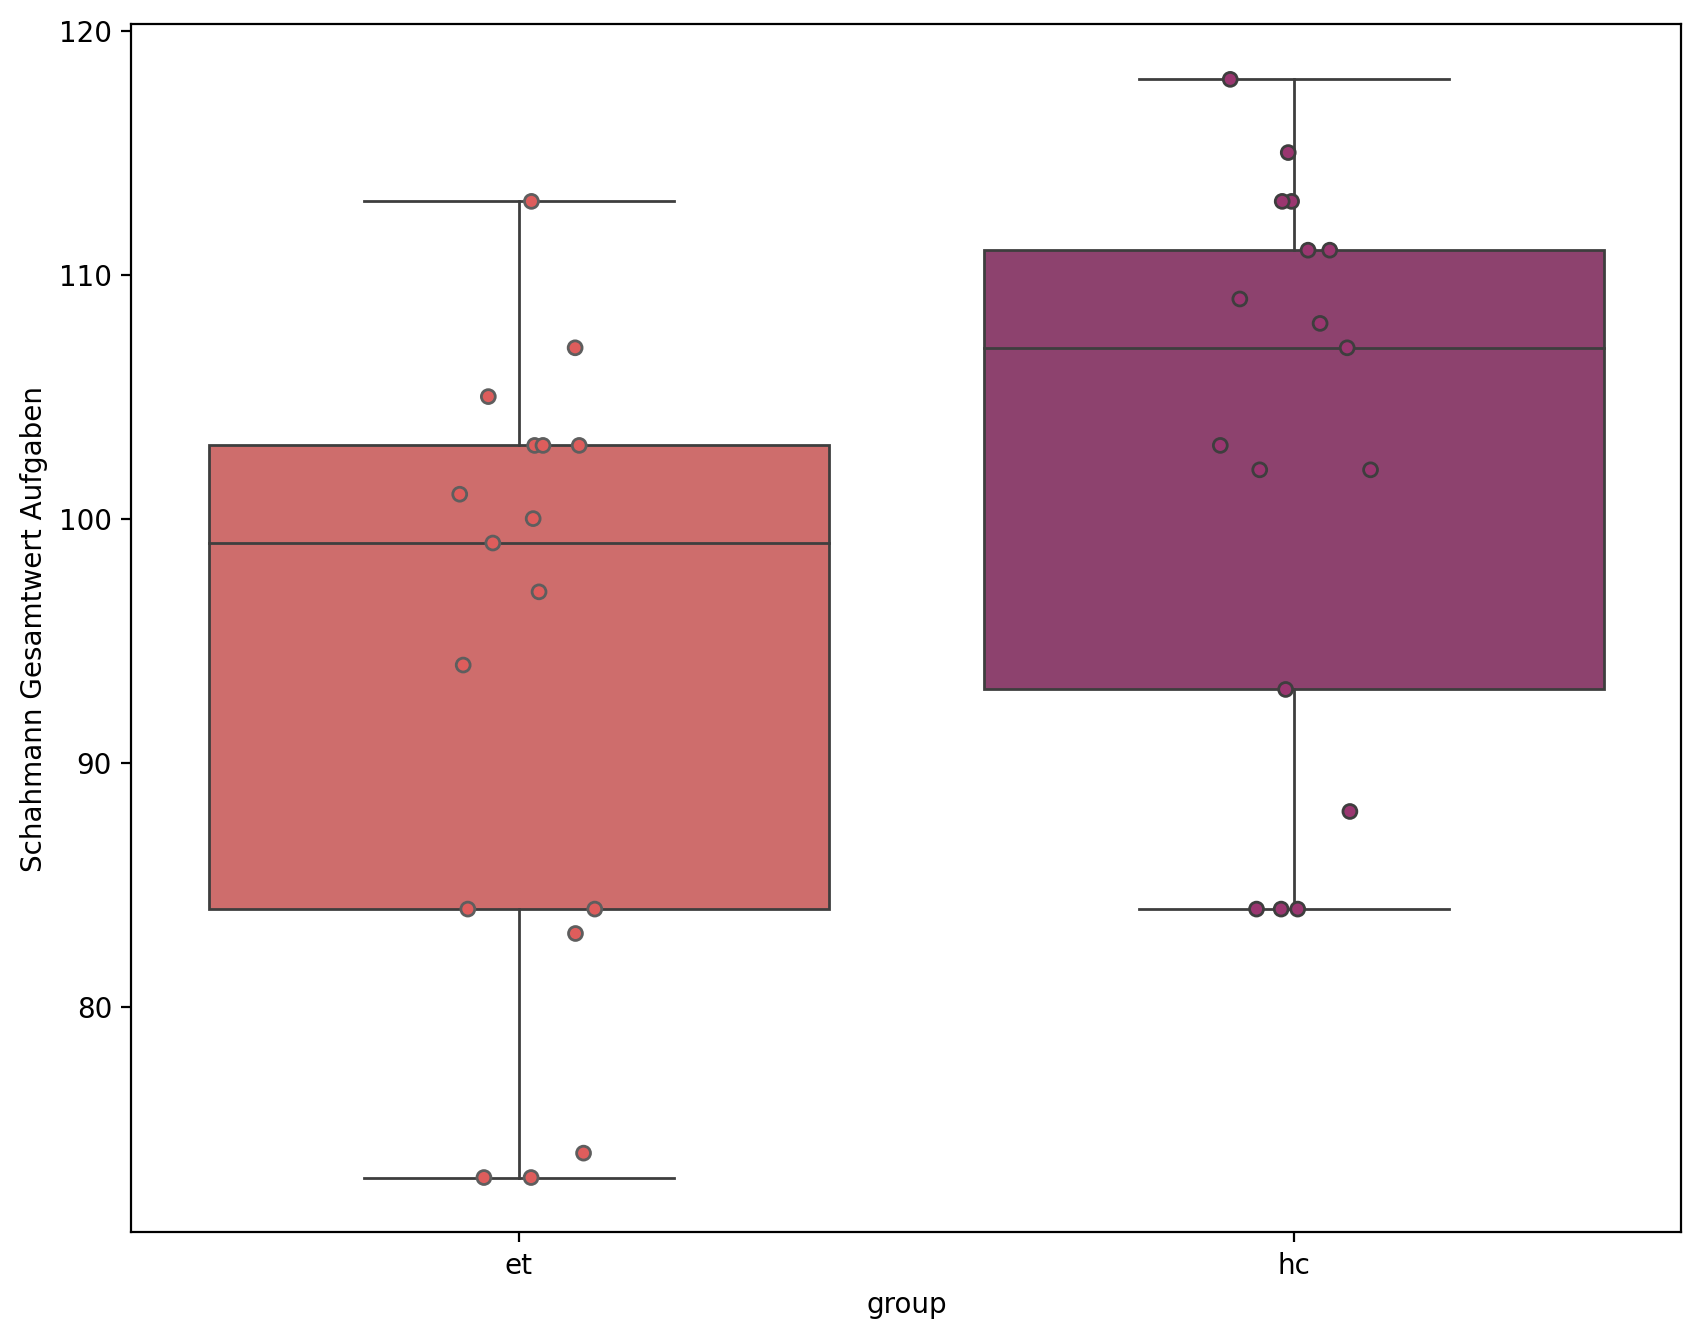

In [218]:
ax = sns.boxplot(x='group',y='Schahmann Gesamtwert Aufgaben',data=match_data, palette='flare',linewidth=1,)
ax = sns.stripplot(x="group", y="Schahmann Gesamtwert Aufgaben",data=match_data, palette='flare',linewidth=1,)

In [211]:
# Run independent samples t-test
bdi_et = match_data[match_data['group'] == 'et']["BDI-Score"]
bdi_hc = match_data[match_data['group'] == 'hc']["BDI-Score"]
t, p = ttest_ind(bdi_et,bdi_hc)

print(f"The difference in age between et and hc is t = {t:.2f}, p = {p:.3f}")

The difference in age between et and hc is t = 1.09, p = 0.283
